**A model that can categorize academic papers based on how they cite each other and their features**

In [1]:
!pip install torch_geometric optuna matplotlib pandas networkx torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 504.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00


In [2]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATConv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.nn import Linear
import optuna

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


In [4]:
node_features_df = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node', inplace=True)



In [5]:
edge_index_df = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])

In [6]:
labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])
labels_df['node'] = labels_df.index
labels_df.set_index('node', inplace=True)

In [7]:
num_nodes = data.num_nodes
num_edges = data.edge_index.shape[1]
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"\nNode features (shape: {node_features_df.shape}):")
print(node_features_df.head())
print(f"\nEdge indices (shape: {edge_index_df.shape}):")
print(edge_index_df.head())
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())

Number of nodes: 2708
Number of edges: 10556

Node features (shape: (2708, 1433)):
      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           0.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        0.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        0.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        0.0        0.0        0.0   
4           0.0        0.0        0.0        1.0        0.0        0.0   

      feature_6  feature_7  feature_8  feature_9  ...  feature_1423  \
node                                              ...                 
0           0.0        0.0        0.0        0.0  ...           0.0   
1           0.0        0.0        0.0        0.0  ...           0.0   
2           0.0        0.0        0.0        0.0  ...           0.0   
3           0.0        0.0        0.0      

In [8]:
class GCNWithAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, out_channels, heads=2)
        self.out = Linear(out_channels * 2, out_channels)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index).relu()
        x = self.gcn2(x, edge_index).relu()
        x = self.gat(x, edge_index).relu()
        x = self.out(x)
        return x

model = GCNWithAttention(dataset.num_features, 64, dataset.num_classes)
print(model)

GCNWithAttention(
  (gcn1): GCNConv(1433, 64)
  (gcn2): GCNConv(64, 64)
  (gat): GATConv(64, 7, heads=2)
  (out): Linear(in_features=14, out_features=7, bias=True)
)


In [9]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc



In [10]:

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    out_channels = trial.suggest_int('out_channels', 16, 64)
    model = GCNWithAttention(dataset.num_features, hidden_channels, out_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(200):
        loss = train()

    acc = test()
    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(f'Best trial: {study.best_trial}')


[I 2024-09-06 15:48:49,666] A new study created in memory with name: no-name-dd819efd-c302-4e5c-8b26-deae45adcdf0
[I 2024-09-06 15:48:59,467] Trial 0 finished with value: 0.755 and parameters: {'hidden_channels': 63, 'out_channels': 63}. Best is trial 0 with value: 0.755.
[I 2024-09-06 15:49:09,685] Trial 1 finished with value: 0.752 and parameters: {'hidden_channels': 125, 'out_channels': 27}. Best is trial 0 with value: 0.755.
[I 2024-09-06 15:49:19,861] Trial 2 finished with value: 0.756 and parameters: {'hidden_channels': 102, 'out_channels': 37}. Best is trial 2 with value: 0.756.
[I 2024-09-06 15:49:28,503] Trial 3 finished with value: 0.753 and parameters: {'hidden_channels': 102, 'out_channels': 58}. Best is trial 2 with value: 0.756.
[I 2024-09-06 15:49:38,310] Trial 4 finished with value: 0.751 and parameters: {'hidden_channels': 55, 'out_channels': 58}. Best is trial 2 with value: 0.756.
[I 2024-09-06 15:49:48,188] Trial 5 finished with value: 0.751 and parameters: {'hidden_

Best trial: FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.756], datetime_start=datetime.datetime(2024, 9, 6, 15, 49, 9, 687826), datetime_complete=datetime.datetime(2024, 9, 6, 15, 49, 19, 861320), params={'hidden_channels': 102, 'out_channels': 37}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_channels': IntDistribution(high=128, log=False, low=32, step=1), 'out_channels': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=2, value=None)


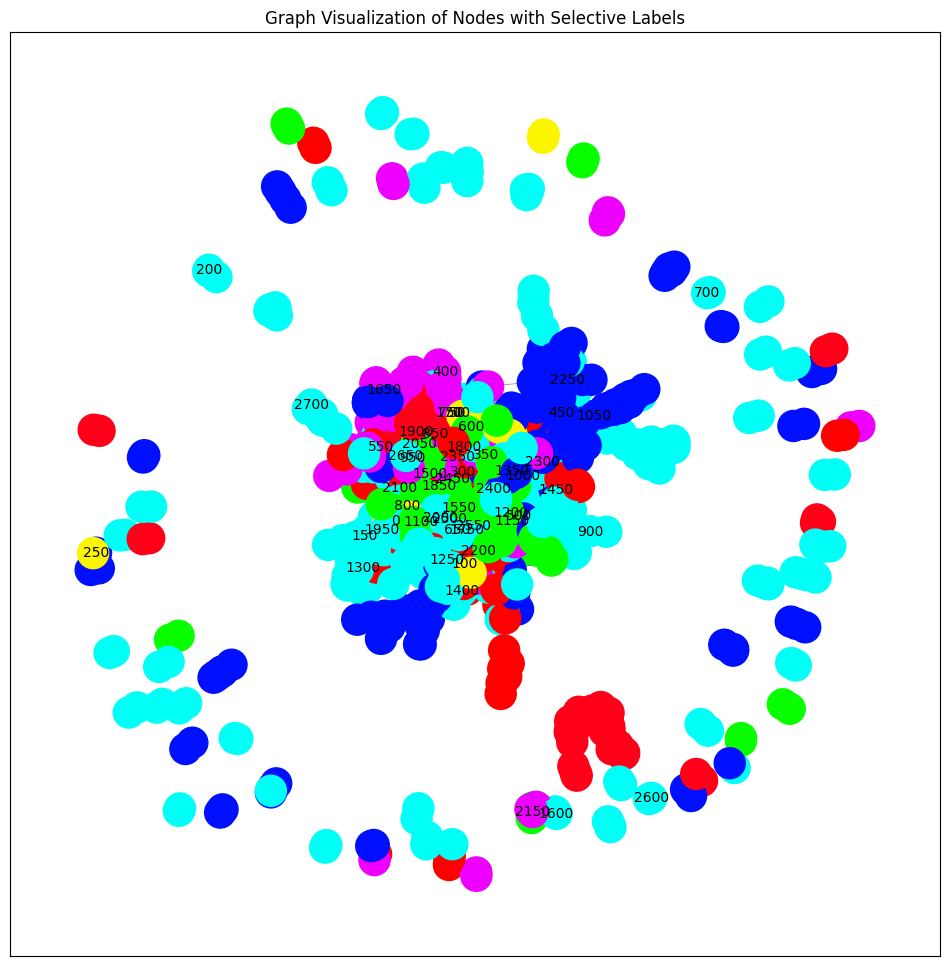

In [19]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=data.y, cmap="hsv")
nx.draw_networkx_edges(G, pos, width=0.5, edge_color="grey")


labels = {i: str(i) for i in range(num_nodes) if i % 50 == 0}  # Only show labels for every 50th node
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

plt.title('Graph Visualization of Nodes with Selective Labels')
plt.show()


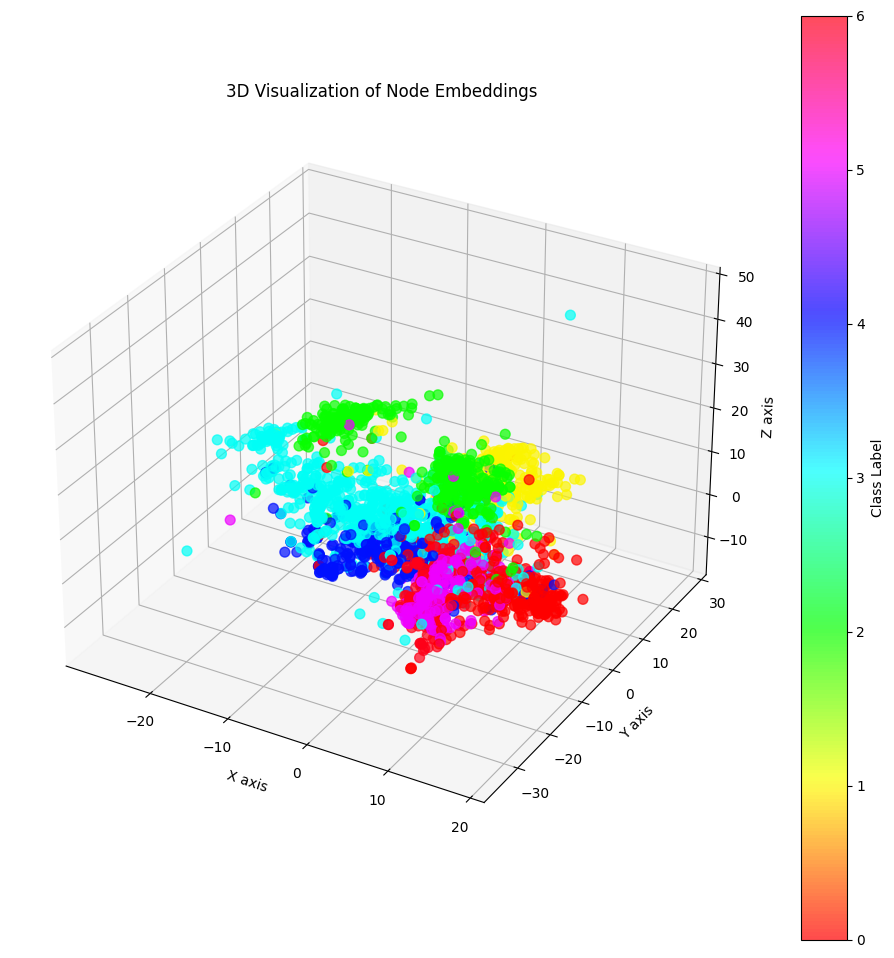

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model.eval()
with torch.no_grad():
    h = model(data.x, data.edge_index)

embed = h.detach().cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the embeddings
sc = ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
                c=data.y.numpy(), cmap='hsv', s=50, alpha=0.7)

# Add a color bar
plt.colorbar(sc, ax=ax, label='Class Label')

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Visualization of Node Embeddings')

# Show the plot
plt.show()


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(pred, true):
    precision = precision_score(true, pred, average='weighted')
    recall = recall_score(true, pred, average='weighted')
    f1 = f1_score(true, pred, average='weighted')
    return precision, recall, f1

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = test()
    precision, recall, f1 = compute_metrics(pred[data.test_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy())
    print(f'Accuracy: {acc*100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')


Accuracy: 75.10%
Precision: 0.78
Recall: 0.75
F1 Score: 0.75


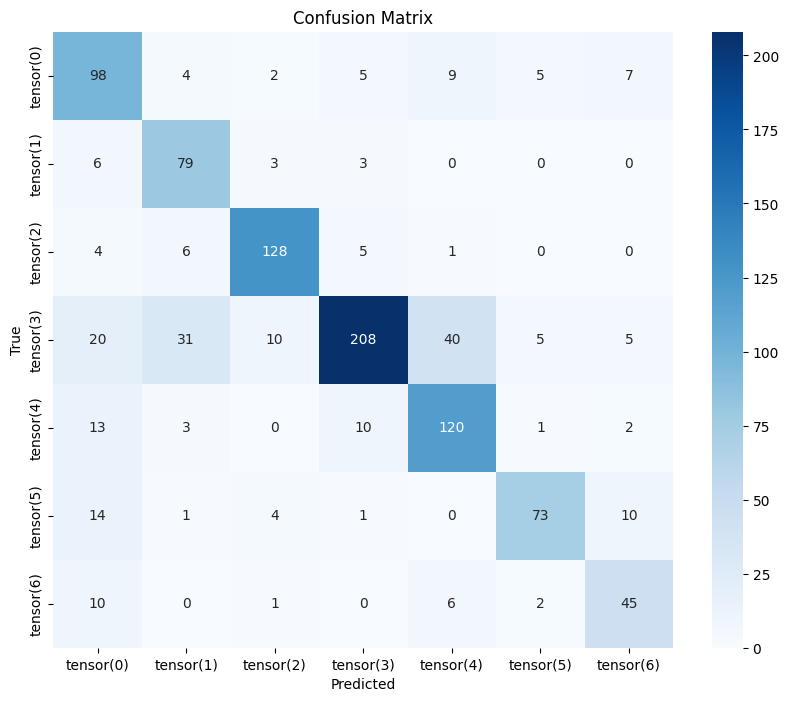

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(pred, true):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.y.unique(), yticklabels=data.y.unique())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    plot_confusion_matrix(pred[data.test_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy())

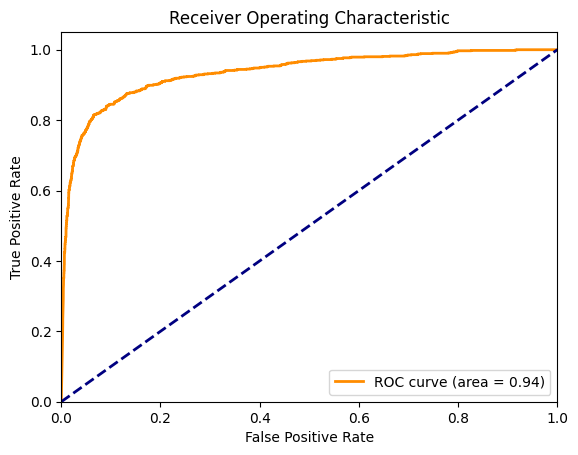

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

def plot_roc_curve(pred, true):
    true_bin = label_binarize(true, classes=np.arange(dataset.num_classes))
    pred_proba = torch.softmax(torch.from_numpy(pred), dim=1).cpu().numpy() # Convert pred to a PyTorch tensor before applying softmax
    fpr, tpr, _ = roc_curve(true_bin.ravel(), pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    plot_roc_curve(out[data.test_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy()) # Changed pred to out

Epoch   0 | Loss: 0.00 | Acc: 75.10%
Epoch  10 | Loss: 0.00 | Acc: 75.10%
Epoch  20 | Loss: 0.00 | Acc: 75.10%
Epoch  30 | Loss: 0.00 | Acc: 75.10%
Epoch  40 | Loss: 0.00 | Acc: 75.10%
Epoch  50 | Loss: 0.00 | Acc: 75.20%
Epoch  60 | Loss: 0.00 | Acc: 75.20%
Epoch  70 | Loss: 0.00 | Acc: 75.20%
Epoch  80 | Loss: 0.00 | Acc: 75.20%
Epoch  90 | Loss: 0.00 | Acc: 75.20%
Epoch 100 | Loss: 0.00 | Acc: 75.20%
Epoch 110 | Loss: 0.00 | Acc: 75.20%
Epoch 120 | Loss: 0.00 | Acc: 75.20%
Epoch 130 | Loss: 0.00 | Acc: 75.20%
Epoch 140 | Loss: 0.00 | Acc: 75.20%
Epoch 150 | Loss: 0.00 | Acc: 75.20%
Epoch 160 | Loss: 0.00 | Acc: 75.20%
Epoch 170 | Loss: 0.00 | Acc: 75.10%
Epoch 180 | Loss: 0.00 | Acc: 75.10%
Epoch 190 | Loss: 0.00 | Acc: 75.10%


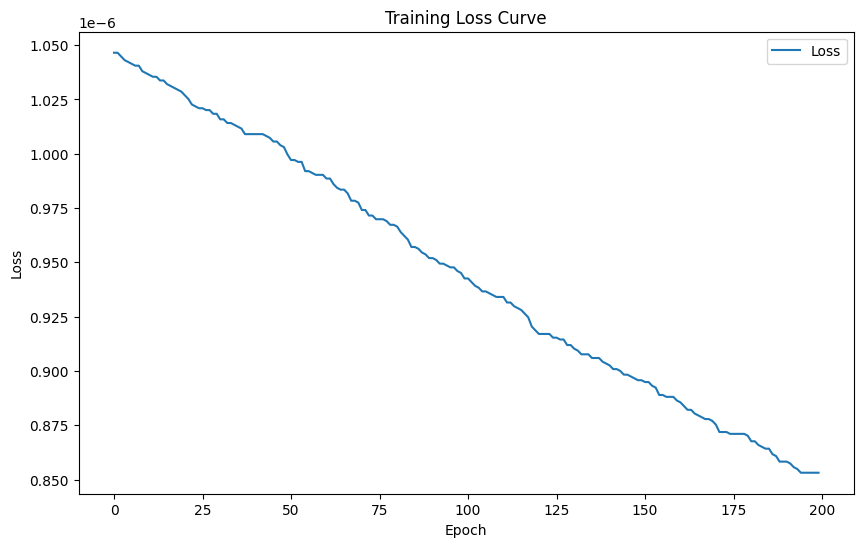

In [27]:
# Track loss history
loss_history = []

for epoch in range(200):
    loss = train()
    loss_history.append(loss)
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


Epoch   0 | Loss: 0.00 | Train Acc: 75.10%
Epoch  10 | Loss: 0.00 | Train Acc: 75.10%
Epoch  20 | Loss: 0.00 | Train Acc: 75.10%
Epoch  30 | Loss: 0.00 | Train Acc: 75.00%
Epoch  40 | Loss: 0.00 | Train Acc: 75.00%
Epoch  50 | Loss: 0.00 | Train Acc: 75.00%
Epoch  60 | Loss: 0.00 | Train Acc: 75.00%
Epoch  70 | Loss: 0.00 | Train Acc: 75.00%
Epoch  80 | Loss: 0.00 | Train Acc: 75.00%
Epoch  90 | Loss: 0.00 | Train Acc: 75.00%
Epoch 100 | Loss: 0.00 | Train Acc: 75.00%
Epoch 110 | Loss: 0.00 | Train Acc: 75.00%
Epoch 120 | Loss: 0.00 | Train Acc: 75.00%
Epoch 130 | Loss: 0.00 | Train Acc: 75.00%
Epoch 140 | Loss: 0.00 | Train Acc: 75.10%
Epoch 150 | Loss: 0.00 | Train Acc: 75.10%
Epoch 160 | Loss: 0.00 | Train Acc: 75.10%
Epoch 170 | Loss: 0.00 | Train Acc: 75.10%
Epoch 180 | Loss: 0.00 | Train Acc: 75.10%
Epoch 190 | Loss: 0.00 | Train Acc: 75.10%


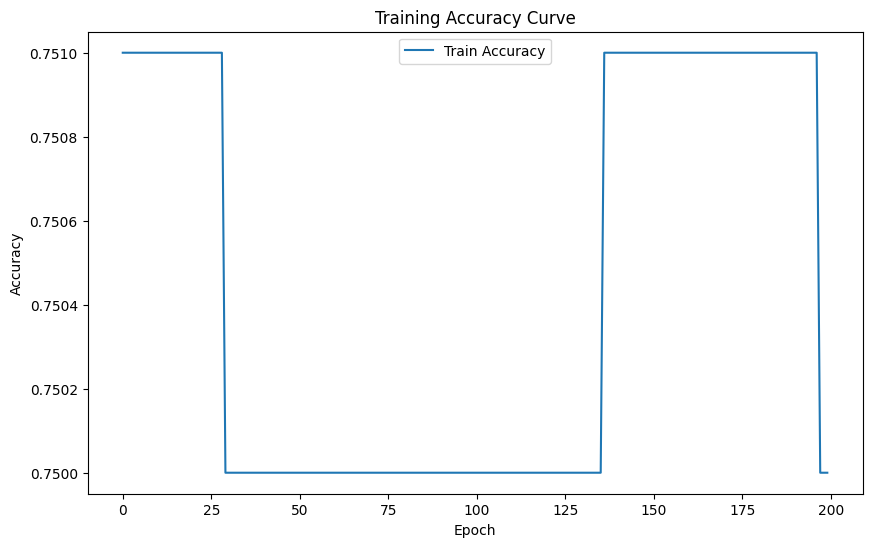

In [28]:
# Add validation metrics tracking
def train_with_validation():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_acc = test()
    return loss.item(), train_acc

train_losses = []
train_accuracies = []

for epoch in range(200):
    loss, acc = train_with_validation()
    train_losses.append(loss)
    train_accuracies.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Train Acc: {acc*100:.2f}%')

# Plot accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()
